In [321]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy
import pulp
from pulp import GLPK
import shapely
import spopt
from spopt.locate import MCLP, simulated_geo_points
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
# ignore deprecation warning - GH pysal/spaghetti#649
import spaghetti


In [322]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import DBSCAN
#import utm
#import hdbscan
import os
import contextily as ctx
import folium
import webbrowser
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import numpy as np

In [323]:
#!Pip install utm

In [324]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point  #

def summarize_clusters(gdf):
    """
    Summarizes the clusters in a GeoDataFrame that includes a 'cluster' label column derived from K-means clustering.
    It now also calculates the total 'raw_visit_counts' for each cluster as weights.

    Parameters:
    - gdf (gpd.GeoDataFrame): GeoDataFrame with 'latitude', 'longitude' for foot traffic points,
                              a 'cluster' column, and 'raw_visit_counts' indicating the volume of visits.
    
    Returns:
    - pd.DataFrame: DataFrame where each row represents a cluster with columns for the
                    number of points in the cluster, total visit counts, the cluster label, 
                    and the centroid geometry.
    """
    # Ensure the 'cluster' column exists
    if 'cluster' not in gdf.columns:
        raise ValueError("GeoDataFrame must include a 'cluster' column")

    # Group by cluster label
    grouped = gdf.groupby('cluster')

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'num_points': grouped.size(),  # Count points per cluster
        'total_visit_counts': grouped['raw_visit_counts'].sum(),  # Sum of visit counts per cluster
        'centroid': grouped.apply(lambda x: Point(x['longitude'].mean(), x['latitude'].mean()))  # Calculate centroid of each cluster
    }).reset_index()

    # Rename columns appropriately
    summary_df.columns = ['cluster_label', 'num_points', 'total_visit_counts', 'geometry']

    # Convert centroids to GeoDataFrame
    summary_df = gpd.GeoDataFrame(
        summary_df, 
        geometry='geometry',
        crs='EPSG:4326'  # Set the coordinate reference system to WGS 84
    )

    return summary_df


## We need to first load the data

In [325]:
# Load API Data
api_data = pd.read_json('/Users/kd6801/Desktop/MiniData/Jersey-City/Jersey_City_NJ_Apartment_data.json')

# Load building foot-traffic data
path_to_NJ_parquet =  '/Users/kd6801/Desktop/MiniData/foot-traffic/jersey_city_full_patterns.parquet'
foot =  pd.read_parquet(path_to_NJ_parquet, engine='pyarrow')


large_apartments_NJ_path = '/Users/kd6801/Desktop/MiniData/large_apartments_Jersey_City.geojson'
large_apartments_NJ =  gpd.read_file(large_apartments_NJ_path)

small_apartment_NJ_path =  '/Users/kd6801/Desktop/MiniData/small_apartments_Jersey_City.geojson'
small_apartment_NJ =   gpd.read_file(small_apartment_NJ_path)


In [326]:
print(f"We have {len(large_apartments_NJ)} large apartment buildings and {len(small_apartment_NJ)} small apartment buildings in Jersey City")
print(f"We have {len(foot)} foot-traffic points in Jersey City")
foot.columns

We have 75 large apartment buildings and 565 small apartment buildings in Jersey City
We have 137807 foot-traffic points in Jersey City


Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs'],
      dtype='object')

## I plan to use K-means method for clustering

In [327]:
from sklearn.cluster import KMeans
import numpy as np

# Convert DataFrame to GeoDataFrame
gdf_foot_traffic = gpd.GeoDataFrame(
    foot, 
    geometry=gpd.points_from_xy(foot.longitude, foot.latitude)
)
gdf_foot_traffic.set_crs(large_apartments_NJ.crs, inplace=True)



# Assuming 'gdf' is your GeoDataFrame containing the foot-traffic points
coords = gdf_foot_traffic[['latitude', 'longitude']]

# Check for NaN values and fill them
coords = coords.fillna(coords.mean())  # Filling NaNs with mean of each column

# Check for infinite values and handle them
coords.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
coords.fillna(coords.mean(), inplace=True)  # Fill new NaNs potentially created

# Running K-means
kmeans = KMeans(n_clusters=200)  
clusters = kmeans.fit_predict(coords.values)

# for certain size of a city, jersey city 15 square miles
# 1/4 square miles per cluster

# Assign clusters back to the GeoDataFrame
gdf_foot_traffic['cluster'] = clusters



In [328]:
gdf_foot_traffic['cluster'].value_counts()
gdf_foot_traffic.columns

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs', 'geometry',
       'cluster'],
      dtype='object')

In [329]:
cluster_summary = summarize_clusters(gdf_foot_traffic)
cluster_summary.head(100)
#cluster_summary.columns

,cluster_label,num_points,total_visit_counts,geometry
0,0,859,79644.0,POINT (-74.06908 40.73638)
1,1,2153,117992.0,POINT (-74.04687 40.72157)
2,2,474,76534.0,POINT (-74.09491 40.70029)
3,3,514,75981.0,POINT (-74.04765 40.75328)
4,4,934,217961.0,POINT (-74.07844 40.71917)
...,...,...,...,...
95,95,789,100707.0,POINT (-74.07664 40.72708)
96,96,444,56123.0,POINT (-74.06463 40.72250)
97,97,347,177955.0,POINT (-74.10171 40.70995)
98,98,443,116487.0,POINT (-74.05366 40.71936)


In [330]:
cluster_summary['weights'] = cluster_summary['total_visit_counts']/100000
cluster_summary

,cluster_label,num_points,total_visit_counts,geometry,weights
0,0,859,79644.0,POINT (-74.06908 40.73638),0.79644
1,1,2153,117992.0,POINT (-74.04687 40.72157),1.17992
2,2,474,76534.0,POINT (-74.09491 40.70029),0.76534
3,3,514,75981.0,POINT (-74.04765 40.75328),0.75981
4,4,934,217961.0,POINT (-74.07844 40.71917),2.17961
...,...,...,...,...,...
195,195,1297,176165.0,POINT (-74.06570 40.72979),1.76165
196,196,451,82137.0,POINT (-74.05095 40.74867),0.82137
197,197,752,894274.0,POINT (-74.06297 40.73225),8.94274
198,198,347,88106.0,POINT (-74.03954 40.71217),0.88106


In [331]:
%matplotlib inline


In [1]:
# quantity demand points (number of clusters)

# previously set it to 60
CLIENT_COUNT = 200

# quantity supply points (Given)
FACILITY_COUNT = 125

# maximum service radius (in distance units) we can use grid search method to fidn the optimal service radius
SERVICE_RADIUS = 50

# number of candidate facilities in optimal solution (We simply halved athe FACILITY_COUNT)
P_FACILITIES = 125

# random seeds for reproducibility
CLIENT_SEED = 222
FACILITY_SEED = 333

# set the solver
#solver = pulp.COIN_CMD(msg=False, warmStart=True)
# set the solver
#solver = GLPK(msg=True)

In [333]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

# Assuming data loading paths are set correctly
# large_apartments_NJ = gpd.read_file("path_to_large_apartments_data.geojson")
# clustered_gdf = gpd.read_file("path_to_clustered_data.geojson")

def clean_coordinates(gdf):
    """ Ensure all geometries are valid and finite """
    # Remove any rows with None or NaN geometries
    gdf = gdf[gdf['geometry'].notna()]
    # Ensure all coordinates are finite
    gdf = gdf[gdf['geometry'].apply(lambda geom: np.isfinite(geom.x) and np.isfinite(geom.y))]
    return gdf

# Clean the data
client_points = clean_coordinates(cluster_summary[['geometry', 'weights']])
facility_points = clean_coordinates(large_apartments_NJ.head(75)[['geometry']])

# Find the index of the point with the largest latitude
index_of_max_lat = client_points.geometry.y.idxmax()

# Drop the point
client_points = client_points.drop(index_of_max_lat)

# Continue with previous steps...


In [334]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from spopt.locate import MCLP
from scipy.spatial import cKDTree
import warnings
from pulp import PULP_CBC_CMD


# `large_apartments_NJ` and `clustered_gdf` are pre-loaded GeoDataFrames containing your supply and demand points respectively


# def calculate_cost_matrix(demand_gdf, supply_gdf, radius):
#     demand_coords = np.array(list(demand_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
#     supply_coords = np.array(list(supply_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
#     # Create a tree from the supply coordinates
#     tree = cKDTree(supply_coords)
#     # Query this tree for distances less than radius to demand points
#     demand_indices = np.arange(len(demand_coords))
#     supply_indices = tree.query_ball_point(demand_coords, r=radius)
    
#     # Create a boolean cost matrix
#     cost_matrix = np.zeros((len(demand_indices), len(supply_coords)), dtype=bool)
#     for demand_idx, nearby_supply_indices in zip(demand_indices, supply_indices):
#         cost_matrix[demand_idx, nearby_supply_indices] = True
    
#     return cost_matrix

# depend on supply and demand points

def calculate_cost_matrix(demand_gdf, supply_gdf, radius):
    demand_coords = np.array(list(demand_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    supply_coords = np.array(list(supply_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    tree = cKDTree(supply_coords)
    demand_indices = np.arange(len(demand_coords))
    supply_indices = [tree.query_ball_point(point, r=radius) for point in demand_coords]
    
    cost_matrix = np.zeros((len(demand_indices), len(supply_coords)), dtype=bool)
    for demand_idx, nearby_supply_indices in zip(demand_indices, supply_indices):
        cost_matrix[demand_idx, nearby_supply_indices] = True
    
    return cost_matrix

# Get weights and cost matrix
weights = client_points['weights'].values
cost_matrix = calculate_cost_matrix(client_points, facility_points, SERVICE_RADIUS)


# Get weights and cost matrix
weights = client_points['weights'].values
cost_matrix = calculate_cost_matrix(client_points, facility_points, SERVICE_RADIUS)

# Setting up MCLP
mclp = MCLP.from_cost_matrix(cost_matrix, weights, SERVICE_RADIUS, P_FACILITIES)

solver = PULP_CBC_CMD()
mclp.solve(solver)


# Solving the MCLP
#mclp.solve(pulp.PULP_CBC_CMD(msg=False))  # Using CBC solver

# if hasattr(mclp, 'facility_client_array'):
#     # This block executes if the 'facility_client_array' attribute exists
#     facility_points['selected'] = mclp.facility_client_array.sum(axis=0) > 0
#     coverage = mclp.facility_client_array.sum() / weights.sum() * 100
#     print(f"{coverage}% coverage is observed")
# else:
#     print("Check MCLP model setup and solution: Expected attributes not found.")


# Results
# facility_points['selected'] = mclp.facility_client_array.sum(axis=0) > 0  # Boolean flag for selected facilities
# coverage = mclp.facility_client_array.sum() / weights.sum() * 100  # Calculate coverage percentage

print(f"{mclp.perc_cov}% coverage is observed")





Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/23a593cef2fb4e58a31dafa0bd3dc0ae-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/23a593cef2fb4e58a31dafa0bd3dc0ae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 204 COLUMNS
At line 16071 RHS
At line 16271 BOUNDS
At line 16545 ENDATA
Problem MODEL has 199 rows, 273 columns and 15123 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 215.85 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -215.85 to -1.79769e+308
Probing was tried 0 times and crea

In [335]:
facility_points.columns

Index(['geometry'], dtype='object')

In [336]:
# import osmnx as ox
# import geopandas as gpd
# import spaghetti
# import matplotlib.pyplot as plt
# import warnings

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     # Specify the location and download the road network
#     place_name = "Jersey City, New Jersey, USA"
#     graph = ox.graph_from_place(place_name, network_type='drive')

#     # Convert to spaghetti Network structure
#     ntw = spaghetti.Network(in_data=ox.graph_to_gdfs(graph, nodes=False, edges=True))

#     # Convert the network edges to a GeoDataFrame
#     streets = spaghetti.element_as_gdf(ntw, arcs=True)

#     # Buffer the streets and create a unified buffer (union of all buffers)
#     streets_buffered = gpd.GeoDataFrame(
#         gpd.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
#         crs=streets.crs,
#         columns=["geometry"]
#     )

#     # # Plotting
#     # fig, ax = plt.subplots(figsize=(10, 10))
#     # streets_buffered.plot(ax=ax, alpha=0.5, color='blue', edgecolor='black')
#     # ax.set_title("Buffered Streets of " + place_name)
#     # plt.show()

#     # put the base map in the background


<AxesSubplot:>

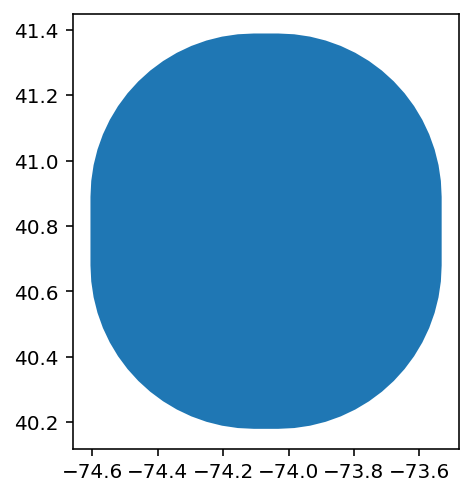

In [337]:
streets_buffered.plot()

In [338]:
client_points

,geometry,weights
0,POINT (-74.06908 40.73638),0.79644
1,POINT (-74.04687 40.72157),1.17992
2,POINT (-74.09491 40.70029),0.76534
3,POINT (-74.04765 40.75328),0.75981
4,POINT (-74.07844 40.71917),2.17961
...,...,...
195,POINT (-74.06570 40.72979),1.76165
196,POINT (-74.05095 40.74867),0.82137
197,POINT (-74.06297 40.73225),8.94274
198,POINT (-74.03954 40.71217),0.88106


In [339]:
# y_max = client_points.geometry.y.idxmax()
# y_min=  client_points.geometry.y.idxmin()
# x_max= client_points.geometry.x.idxmax()
# x_min=  client_points.geometry.x.idxmin()

# print(y_max)
# print(y_min)
# print(x_max)
# print(x_min)

# #client_points.iloc[51]
# client_points.iloc[40]
# #client_points.iloc[119]


# #client_points.iloc[68]

min, ymin, xmax, ymax = client_points.total_bounds

Centroid: POINT (-74.06451795586685 40.72253364254112)


/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_58940/2490631718.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  max_distance = client_points.geometry.distance(centroid).max()


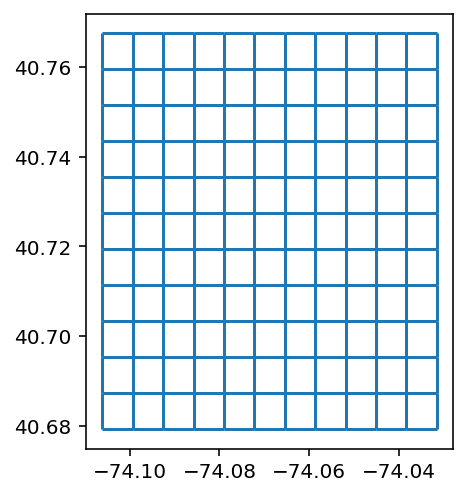

In [340]:
# Calculate the centroid of all points
centroid = client_points.geometry.unary_union.centroid
print("Centroid:", centroid)

# Define the extent of the lattice based on the maximum distance to the centroid
max_distance = client_points.geometry.distance(centroid).max()
#minx, miny, maxx, maxy = centroid.x - max_distance, centroid.y - max_distance, centroid.x + max_distance, centroid.y + max_distance
minx, miny, maxx, maxy = client_points.total_bounds

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Create network with regular lattice centered around centroid
    lattice = spaghetti.regular_lattice((minx, miny, maxx, maxy), 10, exterior=True)
ntw = spaghetti.Network(in_data=lattice)


streets = spaghetti.element_as_gdf(ntw, arcs=True)

streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)

streets.plot();

In [341]:
# client_points = simulated_geo_points(
#     streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
# )
# facility_points = simulated_geo_points(
#     streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
# )


In [342]:
# from shapely import wkt

# #client_points['geometry'] = client_points['geometry'].apply(wkt.loads)
# gdf_points = gpd.GeoDataFrame(client_points, geometry='geometry', crs="EPSG:4326")

# # Create network
# lattice = spaghetti.regular_lattice((-74.093269, 40.678916, -74.02984148, 40.744577), 3, exterior=True)
# ntw = spaghetti.Network(in_data=lattice)

# # Convert network arcs to GeoDataFrame
# streets = spaghetti.element_as_gdf(ntw, arcs=True)

# # Buffer the streets and create a union of the buffered areas
# streets_buffered = gpd.GeoDataFrame(
#     gpd.GeoSeries(streets["geometry"].buffer(0.005).unary_union),
#     crs=streets.crs,
#     columns=["geometry"],
# )

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# streets_buffered.plot(ax=ax, color="blue", alpha=0.5)
# gdf_points.plot(ax=ax, color="red", markersize=5)
# plt.show()

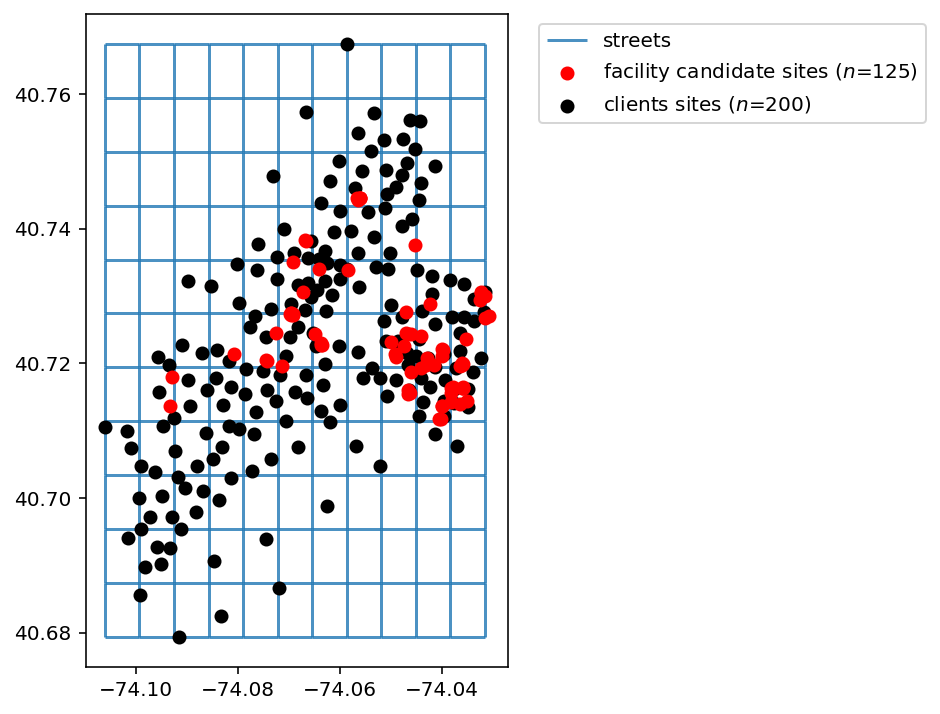

In [343]:

fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [344]:
print(streets_buffered.crs)
print(facility_points.crs)
print(client_points.crs)

print(streets.total_bounds)
print(facility_points.total_bounds)
print(client_points.total_bounds)


# If they are different, decide on a common CRS and transform each GeoDataFrame to that CRS
common_crs = 'EPSG:4326'  # For example, using EPSG:4326 for geographic coordinates
facility_points = facility_points.to_crs(common_crs)
client_points = client_points.to_crs(common_crs)


None
epsg:4326
EPSG:4326
[-74.10608284  40.67934814 -74.03158416  40.76744033]
[-74.093269  40.711723 -74.030831  40.744577]
[-74.10608284  40.67934814 -74.03158416  40.76744033]


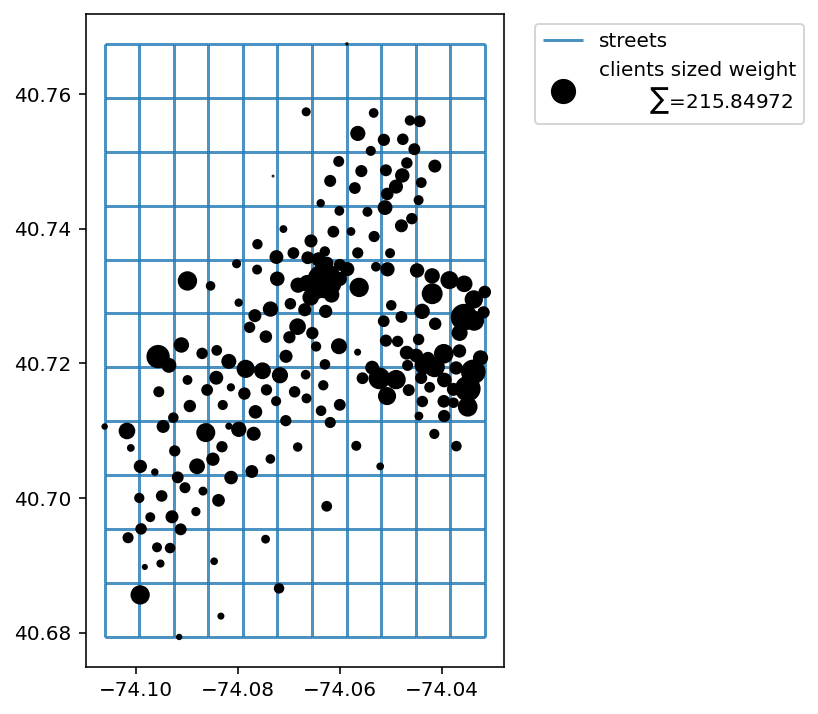

In [345]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
client_points.plot(
    ax=ax,
    color="black",
    label=f"clients sized weight\n\t$\\sum$={client_points['weights'].sum()}",
    markersize=client_points["weights"]*30
)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [346]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

In [347]:
clients_snapped

,geometry
0,POINT (-74.06908 40.73541)
1,POINT (-74.04513 40.72157)
2,POINT (-74.09254 40.70029)
3,POINT (-74.04765 40.75142)
4,POINT (-74.07844 40.71939)
...,...
193,POINT (-74.06545 40.72979)
194,POINT (-74.05190 40.74867)
195,POINT (-74.06545 40.73225)
196,POINT (-74.03954 40.71138)


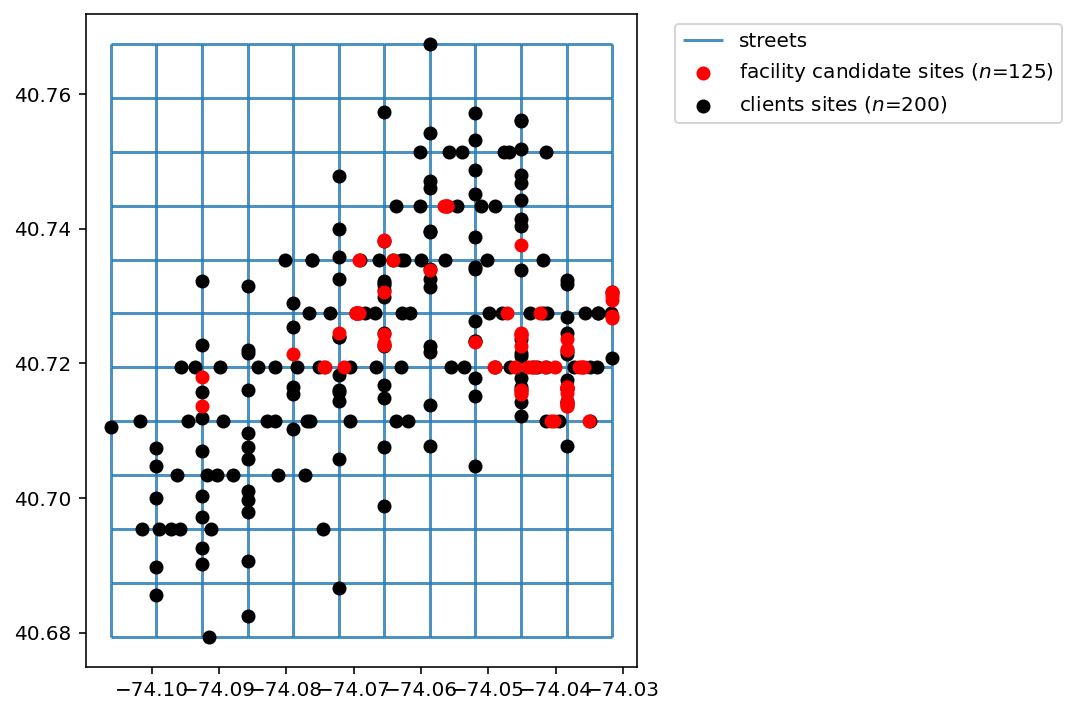

In [348]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [349]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix.shape

(198, 75)

In [350]:
cost_matrix[:5,:]

array([[0.04196918, 0.00499442, 0.05801457, 0.00849703, 0.04978746,
        0.0205318 , 0.0209308 , 0.0209308 , 0.0209308 , 0.0206088 ,
        0.04326386, 0.04379486, 0.04397186, 0.03680086, 0.04284507,
        0.04611507, 0.04587907, 0.04409746, 0.04407846, 0.04523301,
        0.01638303, 0.01610403, 0.01633003, 0.02613924, 0.04971246,
        0.04976646, 0.04979646, 0.04986846, 0.03496786, 0.03502486,
        0.03493586, 0.03604618, 0.03590218, 0.01403119, 0.01996694,
        0.02113434, 0.02138534, 0.04908718, 0.04899018, 0.04926318,
        0.04864018, 0.04353618, 0.04087701, 0.04237807, 0.04348307,
        0.04249707, 0.03900418, 0.02939725, 0.01409856, 0.01385656,
        0.01364756, 0.01372456, 0.01380056, 0.01416856, 0.05248357,
        0.05283657, 0.0347588 , 0.0239968 , 0.04096718, 0.05222446,
        0.04260046, 0.03526186, 0.01462803, 0.00014658, 0.01190064,
        0.04210918, 0.04971846, 0.05248146, 0.05244246, 0.04501918,
        0.00661842, 0.00643142, 0.05191846, 0.02

In [351]:
client_points["weights"]

0      0.79644
1      1.17992
2      0.76534
3      0.75981
4      2.17961
        ...   
195    1.76165
196    0.82137
197    8.94274
198    0.88106
199    0.80616
Name: weights, Length: 198, dtype: float64

In [352]:
weight_array = np.array(client_points["weights"])
mclp_from_cm = MCLP.from_cost_matrix(
    cost_matrix,
    weight_array,
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    name="mclp-network-distance"
)

In [353]:
import watermark
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-05-10T12:29:06.467716-05:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 23.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [354]:
from pulp import PULP_CBC_CMD
solver = PULP_CBC_CMD()
mclp_from_cm.solve(solver)
print(mclp_from_cm)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/0559e045327b4a2484851878086f5ce3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/0559e045327b4a2484851878086f5ce3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 204 COLUMNS
At line 16071 RHS
At line 16271 BOUNDS
At line 16545 ENDATA
Problem MODEL has 199 rows, 273 columns and 15123 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 215.85 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -215.85 to -1.79769e+308
Probing was tried 0 times and crea

In [355]:
print(f"{mclp_from_cm.perc_cov}% coverage is observed")

99.4949494949495% coverage is observed


In [356]:
facility_points["dv"] = mclp_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (-74.04313 40.71972),y0
1,POINT (-74.06409 40.73405),y1
2,POINT (-74.03509 40.71437),y2
3,POINT (-74.06720 40.73055),y3
4,POINT (-74.03815 40.71635),y4
...,...,...
70,POINT (-74.06694 40.73839),y70
71,POINT (-74.06660 40.73820),y71
72,POINT (-74.03828 40.71422),y72
73,POINT (-74.04715 40.72760),y73


In [357]:
distance_metric = "euclidean"
clients_snapped["weights"] = client_points["weights"]
mclp_from_gdf = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    distance_metric=distance_metric,
    name=f"mclp-{distance_metric}-distance"
)

In [358]:
mclp_from_gdf = mclp_from_gdf.solve(solver)
print(f"{mclp_from_gdf.perc_cov}% coverage is observed")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/c3a11ec1c84b479ba930d29e4dddcdb3-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/c3a11ec1c84b479ba930d29e4dddcdb3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 204 COLUMNS
Bad image at line 15370 <     X0000097  OBJ        nan >
Bad image at line 15894 <     X0000228  OBJ        nan >
At line 16071 RHS
At line 16271 BOUNDS
At line 16545 ENDATA
Problem MODEL has 199 rows, 273 columns and 15123 elements
Coin0008I MODEL read with 2 errors
There were 2 errors on input
Option for timeMode changed from cpu to elapsed
** Current model not valid
Option for printingOptions changed from normal to all
** Current model not valid
No match for /var/folders/66/zb_slx1j7jb2

PulpSolverError: Pulp: Error while executing /Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc

In [ ]:
facility_points["predefined_loc"] = 0
facility_points.loc[(0, 1, 3), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

,geometry,dv,predefined_loc
0,POINT (-74.04313 40.71972),y0,1
1,POINT (-74.06409 40.73405),y1,1
2,POINT (-74.03509 40.71437),y2,0
3,POINT (-74.06720 40.73055),y3,1
4,POINT (-74.03815 40.71635),y4,0
...,...,...,...
70,POINT (-74.06694 40.73839),y70,0
71,POINT (-74.06660 40.73820),y71,0
72,POINT (-74.03828 40.71422),y72,0
73,POINT (-74.04715 40.72760),y73,0


In [ ]:
mclp_from_gdf_pre = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    predefined_facility_col="predefined_loc",
    distance_metric=distance_metric,
    name=f"mclp-{distance_metric}-distance-predefined"
)

In [ ]:
# mclp_from_gdf_pre = mclp_from_gdf_pre.solve(solver)
# print(f"{mclp_from_gdf_pre.perc_cov}% coverage is observed")

In [ ]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange"
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid',
 'y16': 'darkorange'}

In [ ]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]

    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("mclp"):
            c = "k"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

KeyError: 'y17'

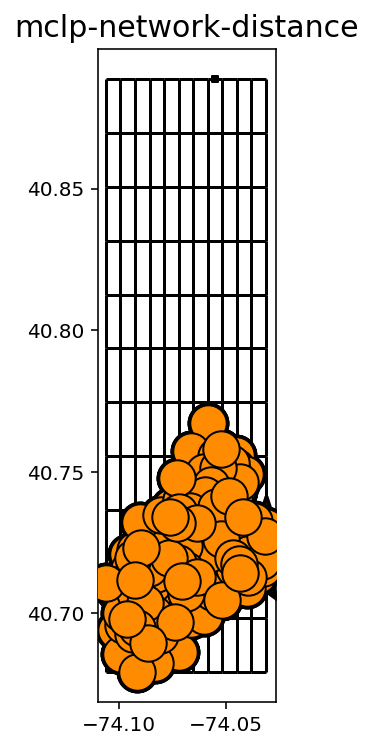

In [ ]:
plot_results(mclp_from_cm, P_FACILITIES, facility_points, clis=client_points)

AttributeError: 'MCLP' object has no attribute 'n_cli_uncov'

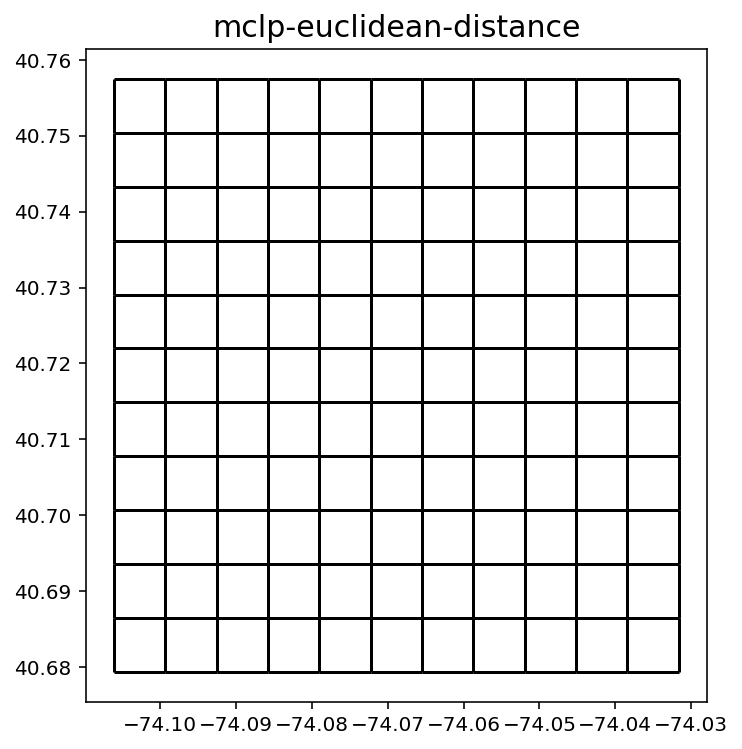

In [ ]:
plot_results(mclp_from_gdf, P_FACILITIES, facility_points, clis=client_points)

AttributeError: 'MCLP' object has no attribute 'fac2cli'

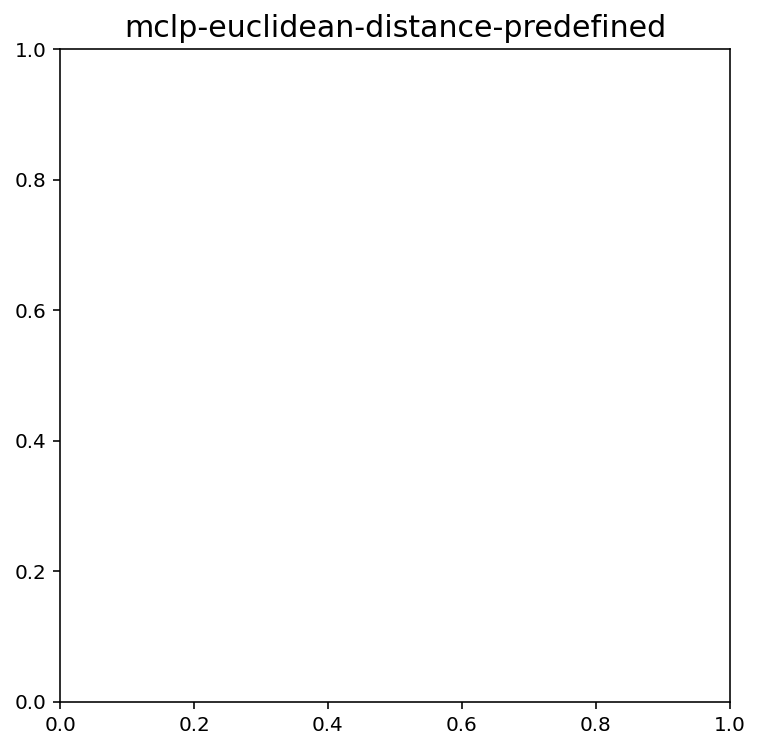

In [ ]:
plot_results(mclp_from_gdf_pre, P_FACILITIES, facility_points, clis=client_points)

KeyError: 'y16'

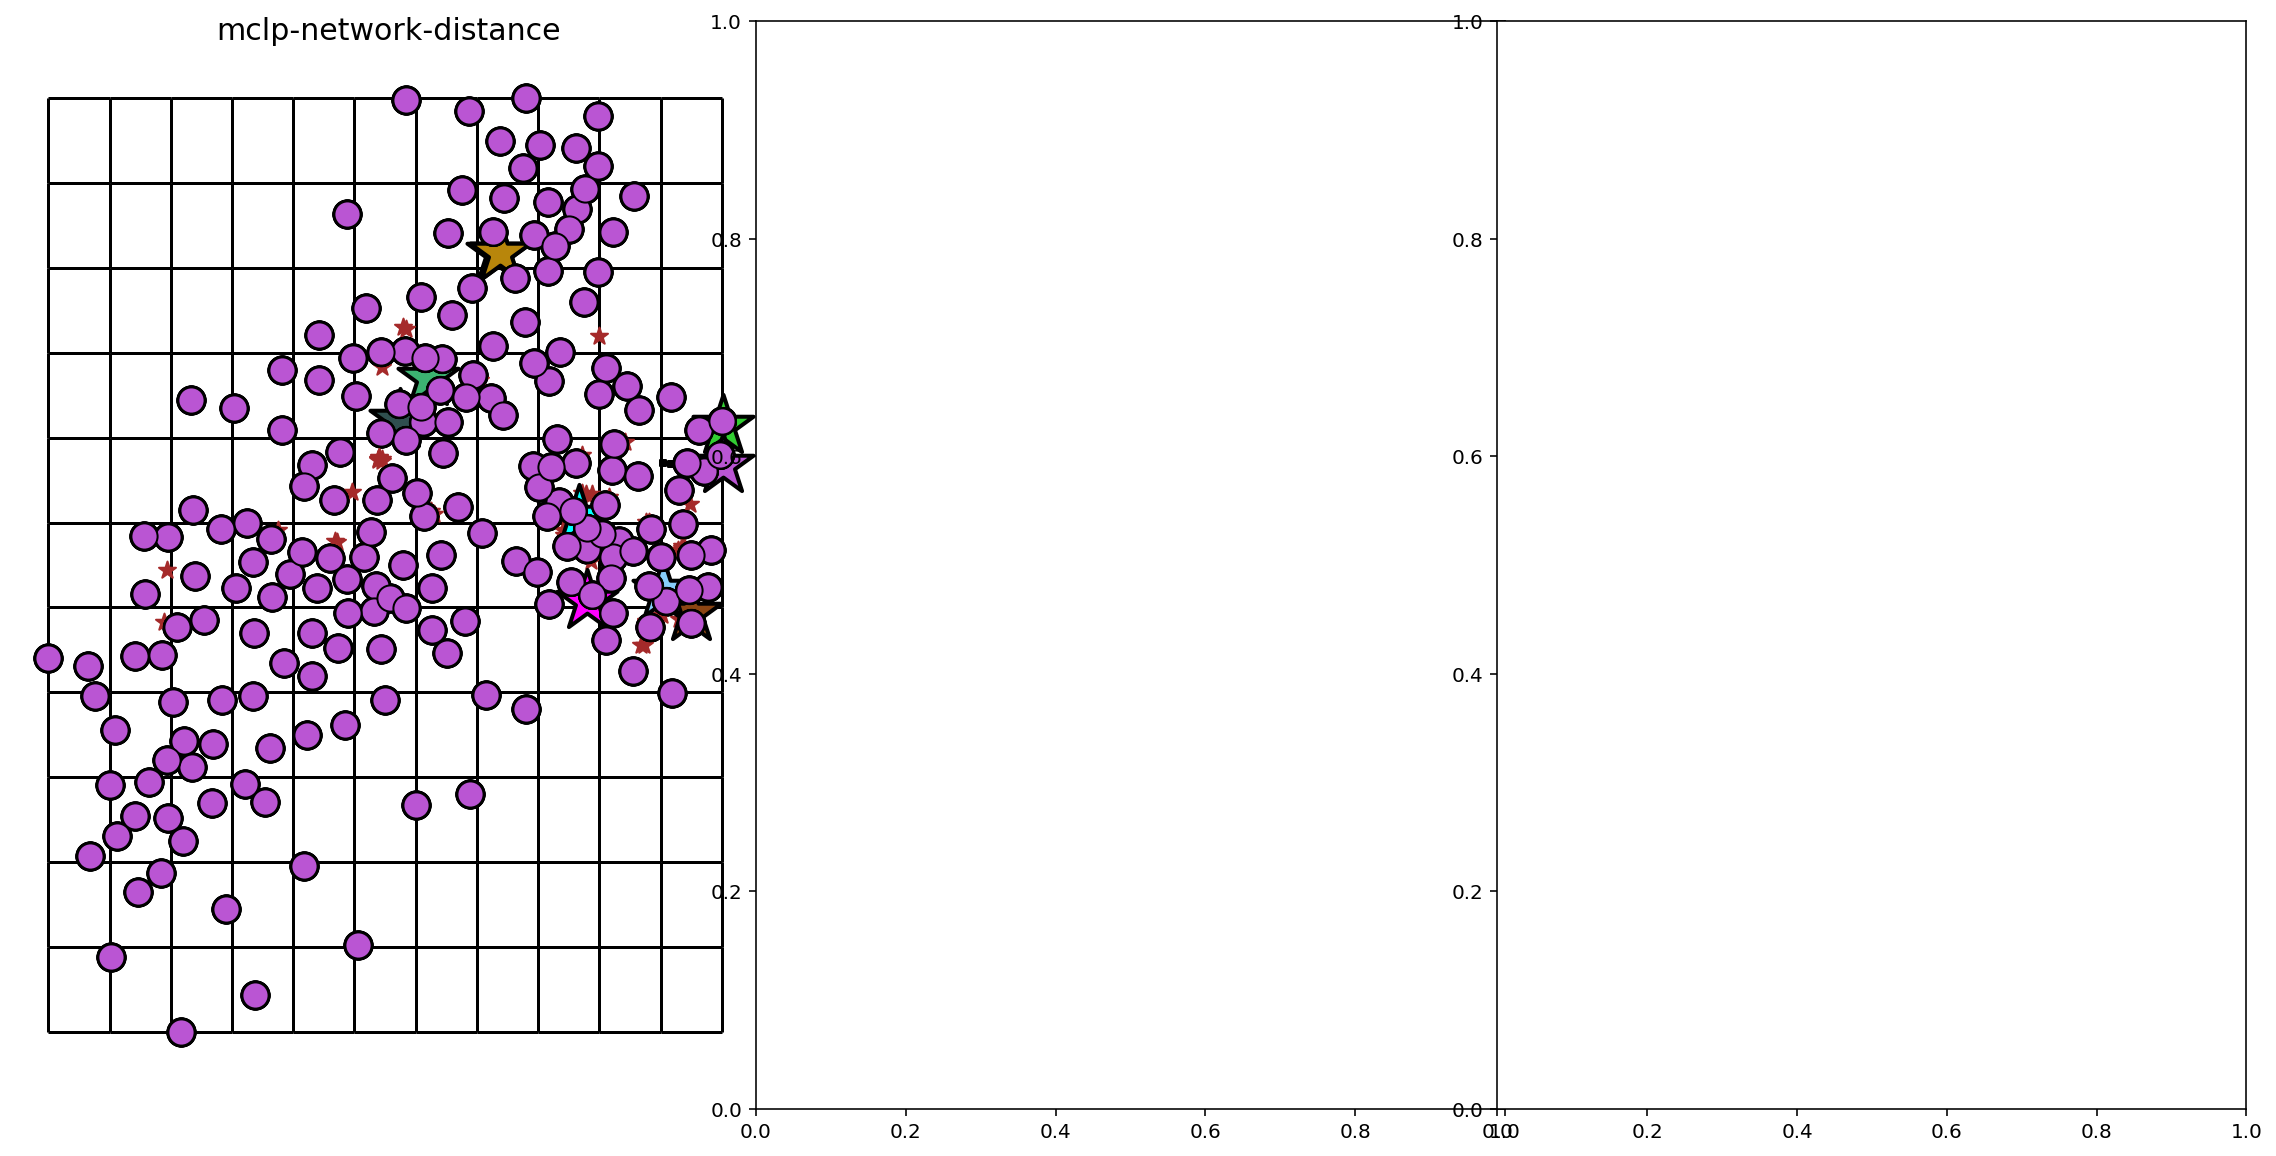

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=-0.01)
for i, m in enumerate([mclp_from_cm, mclp_from_gdf, mclp_from_gdf_pre]):
    plot_results(m, P_FACILITIES, facility_points, clis=client_points, ax=axarr[i])